In [4]:
import sys
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
    
# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import TAPDataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_ssc_area1000_n10.txt"
# basin_list_file = data_dir / "metadata" / "site_lists" / "sites_all.txt"

sequence_length = 30
batch_size = 256

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

# basin_list = basin_list[:10]

data_params = {'data_dir': data_dir,
               'basin_list': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'ssc',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'batch_size': batch_size,
               'train': True,
               'shuffle': True,
               'sequence_length': sequence_length,
               'discharge_col': 'grfr_q',
               'num_workers':1}

dataloader = TAPDataLoader(**data_params)

Loading Basins:   0%|          | 0/650 [00:00<?, ?it/s]

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


In [5]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import start_training


daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.dataset.x_s[basin_list[0]].shape[0]
output_size = 1
hidden_size = 64
dropout = 0.4
key = jax.random.PRNGKey(0)

num_epochs =  5
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.005, num_epochs, 0.5)

model = TAPLSTM(daily_in_size, irregular_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = LSTM(daily_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = EALSTM(daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

model = start_training(model, dataloader, lr_schedule, num_epochs)


Epoch:1 LR:0.0044:   0%|          | 0/671 [00:00<?, ?it/s]

Epoch:2 LR:0.0038:   0%|          | 0/671 [00:00<?, ?it/s]

Process Process-1:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", l

KeyboardInterrupt: 

In [38]:
from metrics import get_all_metrics
from matplotlib.dates import YearLocator, DateFormatter
import datetime 

importlib.reload(evaluate)
from evaluate import predict

basin_subset = np.random.choice(basin_list).tolist()
results = predict(model, dataloader)#, basin_subset=basin_subset)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='o')

plt.title(f"Basin: {basin_subset}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.show()

  0%|          | 0/1451 [00:00<?, ?it/s]

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/Users/Ted/Documents/GitHub/tss-ml/src/data.py", line 216, in __getitem__
    basin, date = self.basin_index_pairs[idx]
                  ~~~~~~~~~~~~~~~~~~~~~~^^^^^
IndexError: list index out of range


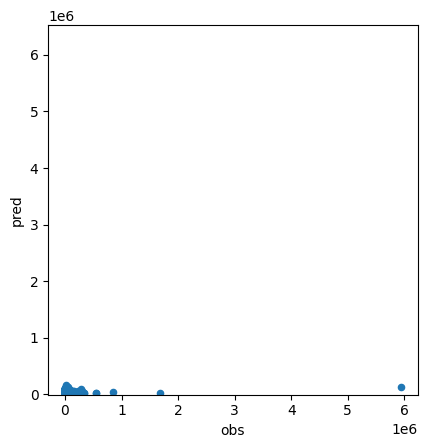

In [29]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.show()